In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import math
import biomart
import pandas as pd

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
results_folder = '/data/workspaces/lag/workspaces/lg-spatial-transcriptomics/working_data/chimp_brain/gokberk/results/snRNA_integration/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}reference_signatures'
run_name = f'{results_folder}cell2location_map'

In [19]:
adata_vis = sc.read_visium(path = '/data/workspaces/lag/workspaces/lg-spatial-transcriptomics/working_data/chimp_brain/gokberk/data/takki_st_count/Takki_leFP_004_D1/Takki_leFP_004_D1/outs/',
                               library_id = 'Takki_leFP_004_D1',
                               source_image_path = '/data/workspaces/lag/workspaces/lg-spatial-transcriptomics/working_data/chimp_brain/gokberk/data/takki_st_count/Takki_leFP_004_D1/Takki_leFP_004_D1/outs/spatial')
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [21]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [10]:
# Read data
adata_ref = sc.read(f'/data/workspaces/lag/workspaces/lg-spatial-transcriptomics/working_data/chimp_brain/gokberk/data/ma_etal2022_chimp_dlPFC_snRNA/processed/PFC_snRNAseq_liftover.h5ad')

In [25]:
# make sure raw data is in the ref data
adata_ref.raw.X

# keep only chimpanzee samples in ref data
adata_ref_chimp = adata_ref[adata_ref.obs["species"]=="Chimpanzee"]

# replace main data layer (X) of adata_ref_chimp with raw counts,
# because cell2location works with raw counts only
adata_ref_chimp = adata_ref_chimp.raw.to_adata()

# make sure you indeed have integers/counts in your anndata 
# object
print(adata_ref_chimp.X)

# change column name _index to features, because this default
# column name causes issues later on
adata_ref_chimp.var.rename(columns={"_index": "features"}, inplace=True)

<610719x28216 sparse matrix of type '<class 'numpy.float64'>'
	with 1698177212 stored elements in Compressed Sparse Row format>

In [52]:
# Read the chimp GTF file as a dataframe
gtf_df = pd.read_csv("/data/workspaces/lag/workspaces/lg-spatial-transcriptomics/working_data/chimp_brain/gokberk/resources/ref_genomes_from10x/ref_freshf/chimp_ref/genes/protein_coding_genes_wGeneNames.gtf", sep="\t", header=None)

# Extract gene IDs and gene names
gtf_df['gene_ID'] = gtf_df[8].str.extract(r'gene_id "(.*?)";')
gtf_df['gene_name'] = gtf_df[8].str.extract(r'gene_name "(.*?)";')

gtf_df_clean = gtf_df[['gene_ID', 'gene_name']].copy()

# Display the extracted gene IDs and gene names
print(gtf_df_clean)

# Ensure the index of gtf_df_clean has unique values in the gene_name column
gtf_df_clean_unique = gtf_df_clean.drop_duplicates(subset='gene_name').set_index('gene_name')

                  gene_ID gene_name
0      ENSPTRG00000000799     HOOK1
1      ENSPTRG00000049634    RNF223
2      ENSPTRG00000049400      PRR9
3      ENSPTRG00000050454    H2BC21
4      ENSPTRG00000001964    FAM71A
...                   ...       ...
17612  ENSPTRG00000003337     AKIP1
17613  ENSPTRG00000052272     DMAC2
17614  ENSPTRG00000009762    ACTBL2
17615  ENSPTRG00000009765   TSPAN10
17616  ENSPTRG00000049595    HS3ST6

[17617 rows x 2 columns]


In [65]:
# Map the gene_ID column from gtf_df_clean to adata_ref_chimp.var based on the gene_name column
adata_ref_chimp.var['gene_ID'] = adata_ref_chimp.var['features'].map(gtf_df_clean_unique['gene_ID'])

# Set gene_ID values as the index in the adata_ref_chimp.var DataFrame
adata_ref_chimp.var.set_index('gene_ID')

# Display the updated adata_ref_chimp.var DataFrame
print(adata_ref_chimp.var)

# If the GTF file doesn't have ensembl ID for a gene symbol, fill that NaN value with
# the gene symbol. Genes without an Ensembl ID will be filtered out down in the pipeline.
#TODO see if this makes sense for the analysis, post an issue to cell2loc github page!
adata_ref_chimp.var['gene_ID'].fillna(adata_ref_chimp.var['features'], inplace=True)
adata_ref_chimp.var.index = adata_ref_chimp.var['gene_ID']

                         features             gene_ID
gene_ID                                              
NaN                  RP11-54O7.16                 NaN
NaN                   RP11-54O7.1                 NaN
NaN                   RP11-54O7.2                 NaN
NaN                   RP11-54O7.3                 NaN
ENSPTRG00000023092         SAMD11  ENSPTRG00000023092
...                           ...                 ...
NaN                 RP13-228J13.1                 NaN
ENSPTRG00000046127          VAMP7  ENSPTRG00000046127
ENSPTRG00000022504         EIF1AY  ENSPTRG00000022504
ENSPTRG00000022505         RPS4Y2  ENSPTRG00000022505
NaN                        TTTY3B                 NaN

[28216 rows x 2 columns]


/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


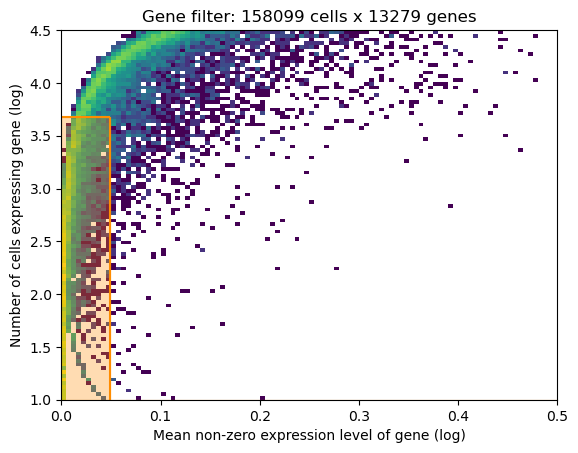

In [70]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref_chimp, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref_chimp = adata_ref_chimp[:, selected].copy()

In [71]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata = adata_ref_chimp, 
                        # 10X reaction / sample / batch
                        batch_key='samplename', 
                        # cell type, covariate used for constructing signatures
                        labels_key='subclass', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['tech_rep']
                       )

/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [72]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref_chimp) 

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'samplename',
│   'labels_key': 'subclass',
│   'categorical_covariate_keys': ['tech_rep'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   4    │
│         n_cells          │ 158099 │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   29   │
│          n_vars          │ 13279  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['samplename'] │   PTB165   │          0          │
│                         │   PTB166   │          1          │
│                         │  PTB1841   │          2          │
│                         │  PTB2169   │          3          │
└─────────────────────────┴────────────┴─────────────────────┘

                    labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['subclass'] │ ADARB2 KCNG1 │          0          │
│                       │    Astro     │          1          │
│                       │     Endo     │          2          │
│                       │    Immune    │          3          │
│                       │   L2-3 IT    │          4          │
│                       │  L3-5 IT-1   │          5          │
│                       │  L3-5 IT-2   │          6          │
│                       │  L3-5 IT-3   │          7          │
│                       │    L5 ET     │          8          │
│                       │   L5-6 NP    │          9          │
│                       │    L6 CT     │         10          │
│                       │   L6 IT-1    │         11          │
│                       │   L6 IT-2    │         12          │
│                       │     L6B      │         13          │
│                       │  LAMP5 LHX6  │         14          │
│                       │  LAMP5 RELN  │         15          │
│                       │    Micro     │         16          │
│                       │     OPC      │         17          │
│                       │    Oligo     │         18          │
│                       │      PC      │         19          │
│                       │    PVALB     │         20          │
│                       │  PVALB ChC   │         21          │
│                       │      RB      │         22          │
│                       │     SMC      │         23          │
│                       │     SST      │         24          │
│                       │   SST HGF    │         25          │
│                       │   SST NPY    │         26          │
│                       │     VIP      │         27          │
│                       │     VLMC     │         28          │
└───────────────────────┴──────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['tech_rep'] │  PTB165_1  │          0          │
│                       │  PTB165_2  │          1          │
│                       │  PTB165_3  │          2          │
│                       │  PTB165_4  │          3          │
│                       │  PTB166_1  │          4          │
│                       │  PTB166_2  │          5          │
│                       │  PTB166_3  │          6          │
│                       │  PTB166_4  │          7          │
│                       │ PTB1841_1  │          8          │
│                       │ PTB1841_2  │          9          │
│                       │ PTB1841_3  │         10          │
│                       │ PTB1841_4  │         11          │
│                       │ PTB2169_1  │         12          │
│                       │ PTB2169_2  │         13          │
│                       │ PTB2169_3  │         14          │
│                       │ PTB2169_4  │         15          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

In [73]:
mod.train(max_epochs=250)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 250/250: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [19:23:03<00:00, 274.72s/it, v_num=1, elbo_train=1.2e+9]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [19:23:03<00:00, 279.14s/it, v_num=1, elbo_train=1.2e+9]


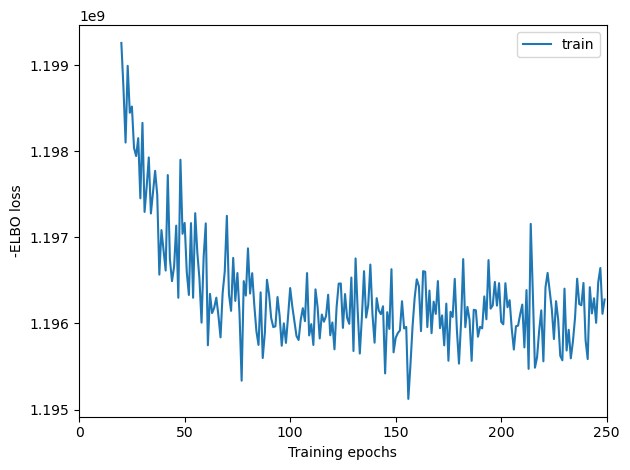

In [74]:
mod.plot_history(20)

In [75]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref_chimp = mod.export_posterior(
    adata_ref_chimp, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref_chimp.write(adata_file)

/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [02:58<00:00,  5.61it/s]


In [77]:
#adata_ref_chimp = mod.export_posterior(
#    adata_ref_chimp, use_quantiles=True,
#    # choose quantiles
#    add_to_obsm=["q05","q50", "q95"],
#    sample_kwargs={'batch_size': 2500, 'use_gpu': False}
#)

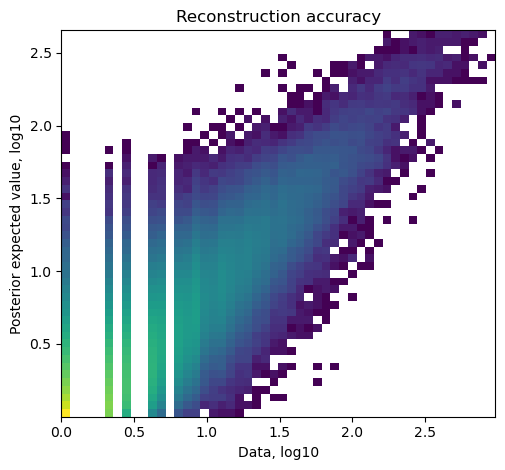

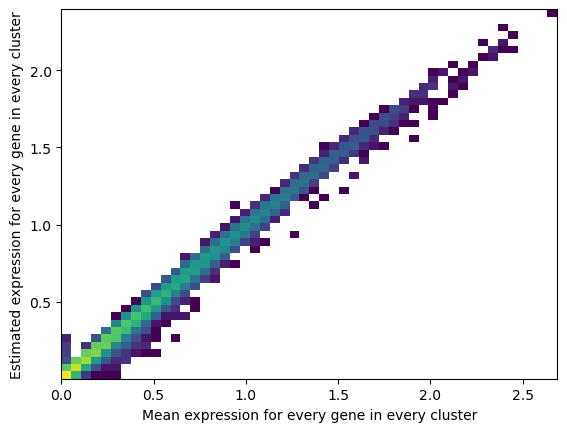

In [78]:
mod.plot_QC()

In [7]:
# load the model and output h5ad when you want to continue analysis
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref_chimp = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref_chimp)

INFO     File                                                                                                      
         /data/workspaces/lag/workspaces/lg-spatial-transcriptomics/working_data/chimp_brain/gokberk/results/snRNA_
         integration/reference_signatures/model.pt already downloaded                                              


/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDa

Epoch 1/127:   1%|▊                                                                                                 | 1/127 [00:05<10:33,  5.03s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/127:   1%|▊                                                                                                 | 1/127 [00:05<10:38,  5.06s/it, v_num=1]


In [8]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref_chimp.varm.keys():
    inf_aver = adata_ref_chimp.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref_chimp.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref_chimp.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref_chimp.uns['mod']['factor_names']]].copy()

inf_aver.columns = adata_ref_chimp.uns['mod']['factor_names']

inf_aver.iloc[0:5, 0:5]

,ADARB2 KCNG1,Astro,Endo,Immune,L2-3 IT
gene_ID,,,,,
ENSPTRG00000022530,0.055655,0.021912,0.017105,0.019347,0.125163
ENSPTRG00000023996,0.043499,0.011349,0.004452,0.005270,0.086816
ISG15,0.099838,0.019784,0.195977,0.041381,0.142647
ENSPTRG00000050180,0.447587,0.144736,0.211132,0.069168,0.802636
ENSPTRG00000051432,0.049639,0.024133,0.015432,0.009399,0.093496


In [22]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [23]:
np.isnan(np.sum(adata_vis.X))

False

In [24]:
adata_vis

AnnData object with n_obs × n_vars = 3735 × 10782
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: 'spatial', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial', 'MT'

In [25]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=4,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=50 # changed this parameter to 50 instead of the default 20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3735  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10782 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                      batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Takki_leFP_004_D1 │          0          │
└─────────────────────┴───────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30000/30000: 100%|█| 30000/30000 [46:45:09<00:00,  5.52s/it, v_num

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [46:45:09<00:00,  5.61s/it, v_num


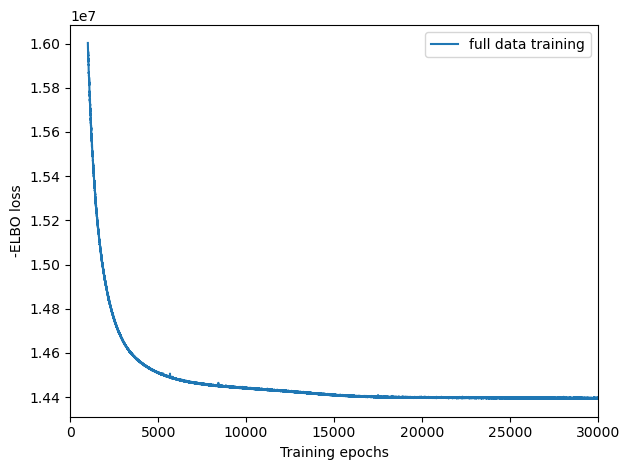

In [26]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [27]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/home/gokala/.conda/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling local variables, batch: 100%|███| 1/1 [03:02<00:00, 182.79s/it]
Sampling global variables, sample: 100%|█| 999/999 [03:22<00:00,  4.92it


'/data/workspaces/lag/workspaces/lg-spatial-transcriptomics/working_data/chimp_brain/gokberk/results/snRNA_integration/cell2location_map/sp.h5ad'

In [ ]:
# Load data to continue analysis afterwards
#adata_file = f"{run_name}/sp.h5ad"
#adata_vis = sc.read_h5ad(adata_file)
#mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

In [29]:
# plot some QC metrics

if True:
    mod.plot_QC()
    plt.savefig(f"{run_name}/reconstruction_accuracy_histogram.png",
                bbox_inches='tight')
    plt.close()

fig = mod.plot_spatial_QC_across_batches()
fig
fig.savefig(f"{run_name}/RNAcounts_cellAbundance_detectionSensitivity.png", bbox_inches='tight')
plt.close()

In [28]:
def plot_spatial_per_cell_type(adata, cell_type='total_counts', samples = adata_vis.obs['sample'].cat.categories,
                               ncol=3, prefix='', figsize=(24, 6), vmax_quantile=0.992):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'{prefix}{cell_type}'
    vmax = np.quantile(adata.obs[col_name].values, vmax_quantile)
    adata.obs[cell_type] = adata.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s)
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False)
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    if len(samples) < len(axs.flatten()):
        for i in range(len(samples), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
        
    fig.tight_layout(pad=0.5)
        
    return fig

In [30]:
from re import sub
import os

adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']


with mpl.rc_context({"axes.facecolor": "black"}):
        clust_names = adata_vis.uns['mod']['factor_names']

        for s in adata_vis.obs['sample'].unique():

            s_ind = adata_vis.obs['sample'] == s
            s_keys = list(adata_vis.uns['spatial'].keys())
            s_spatial = np.array(s_keys)[[s in i for i in s_keys]][0]

            fig = sc.pl.spatial(adata_vis[s_ind, :], cmap='magma',
                                color=clust_names, ncols=5, library_id=s_spatial,
                                size=1.3, img_key='hires', alpha_img=1,
                                vmin=0, vmax='p99.2',
                                return_fig=True, show=False)

            fig_dir = f"{run_name}/spatial/"
            if not os.path.exists(fig_dir):
                os.mkdir(fig_dir)
            fig_dir = f"{run_name}/spatial/per_sample/"
            if not os.path.exists(fig_dir):
                os.mkdir(fig_dir)

            plt.savefig(f"{fig_dir}W_cell_abundance_q05_{s}.png",
                        bbox_inches='tight')
            plt.close()

In [31]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['L2-3 IT', 'L3-5 IT-1', 'L3-5 IT-3', 'L6 CT', 'Oligo', 'Astro']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = cell2location.utils.select_slide(adata_vis, 'Takki_leFP_004_D1')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
    fig.savefig(f"{run_name}/multiCellTypes.png", bbox_inches='tight')
    fig.clear()
    plt.close(fig)